### This notebook analyzes if the solution maps from initial condition to reachable set parameters are convex or not 

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.spatial import ConvexHull
from scipy.optimize import linprog
import sys
sys.path.append('../')
from src.reachset import random_sampling_in_hull
from gen_reachset_train import solve
%load_ext autoreload
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
data = np.load('../saved/controllable_set/data.npy')
with open('../saved/controllable_set/lander.pkl', 'rb') as f:
        lander = pickle.load(f)
N = 100

In [4]:
indices = [2, 3, 5, 6, 7]
data_5d = data[:, indices]
data_bounds = (np.min(data_5d, axis=0), np.max(data_5d, axis=0))
data_normalized = (data_5d - data_bounds[0]) / (data_bounds[1] - data_bounds[0])
hull_5d = ConvexHull(data_normalized, qhull_options='Q12')

In [5]:
samples = random_sampling_in_hull(hull_5d.equations, (np.zeros(5), np.ones(5)), 1000)

c:\Users\ktomita3\Documents\001_workspace\learning-hda-reachability\dev\..\src\reachset\ic_sampler.py:18: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  if not (np.dot(eq[:-1], point) + eq[-1] <= 0):


In [63]:
def solve4bounds(hull, data_point):
    A_ub = hull_5d.equations[:, :-1]
    b_ub = -hull_5d.equations[:, -1]

    # solve for max and min for each dimension
    maxs = np.zeros(5)
    mins = np.zeros(5)
    for i in range(5):
        c = np.zeros(5)
        c[i] = 1
        A_eq = np.zeros((5, 5))
        b_eq = np.zeros(5)
        for j in range(5):
            if i == j:
                continue
            A_eq[j, j] = 1
            b_eq[j] = data_point[j]

        mins[i] = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq).fun
        maxs[i] = -linprog(-c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq).fun

    return mins, maxs

def solve4reachset(param_name, param_idx, param_bounds, n, nominal_x, data_bounds):
    param_min, param_max = param_bounds
    param_name = 'altitude'
    ic_values = np.linspace(param_min, param_max, n)
    ic_list = []
    for i in range(n):
        ic = nominal_x.copy()
        ic[param_idx] = ic_values[i]
        ic = ic * (data_bounds[1] - data_bounds[0]) + data_bounds[0]
        ic[4] = np.round(ic[4], decimals=2)
        ic_list.append(ic)

    reach_data = solve(ic_list, lander, N)
    return np.array(reach_data)

def visualize(reach_data, param_idx, param_name, fig=None, axs=None):
    if fig is None:
        fig, axs = plt.subplots(2, 2, figsize=(5, 5))
    params = reach_data[:, param_idx]
    y_data_indices = [5, 7, 10, 9]
    y_labels = ['x-max', 'x-min', 'y-max', 'x-ymax']
    axs = axs.flatten()
    for i in range(4):
        axs[i].plot(params, reach_data[:, y_data_indices[i]])
        axs[i].set_xlabel(param_name)
        axs[i].set_ylabel(y_labels[i])
    plt.tight_layout()
    return fig, axs
    

In [55]:
n_sample = 3
data_points = samples[np.random.choice(samples.shape[0], n_sample, replace=False)]
center = np.mean(samples, axis=0)

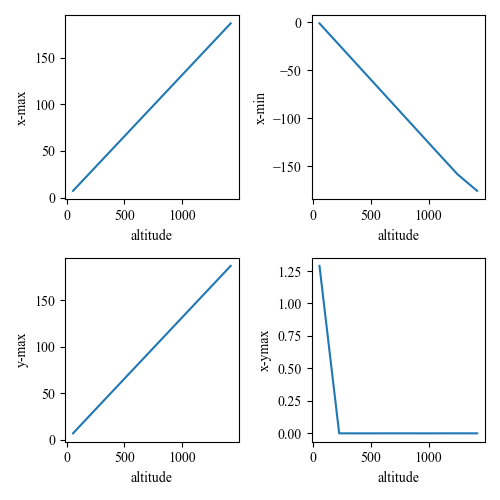

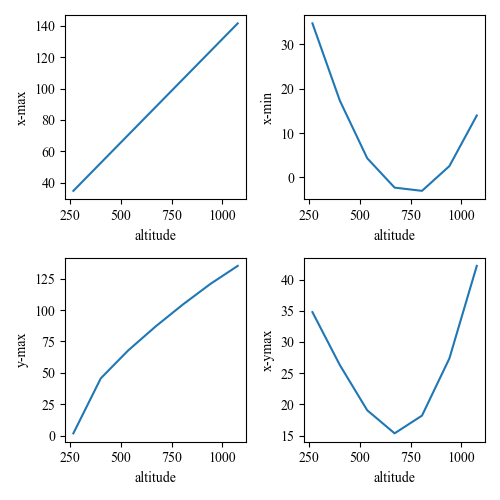

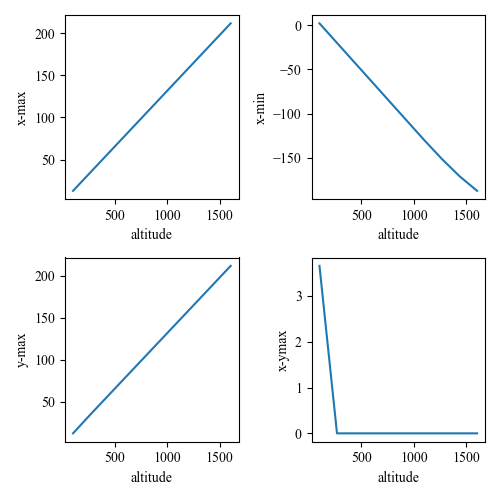

In [64]:
n = 10
param_idx = 0
param_name = 'altitude'

for data_point in data_points:
    mins, maxs = solve4bounds(hull_5d, data_point)
    reach_data = solve4reachset(param_name, param_idx, (mins[param_idx], maxs[param_idx]), n, data_point, data_bounds)
    fig, axs = visualize(reach_data, param_idx, param_name)
    plt.show()

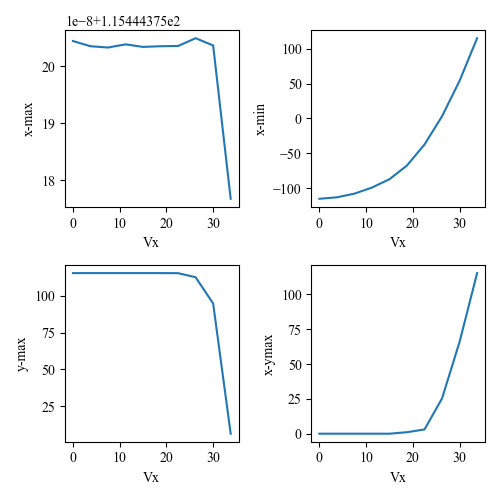

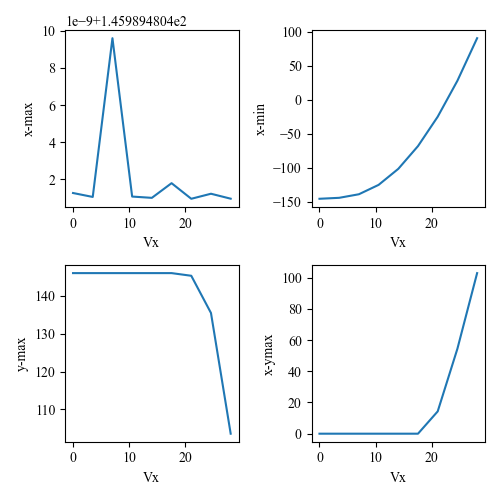

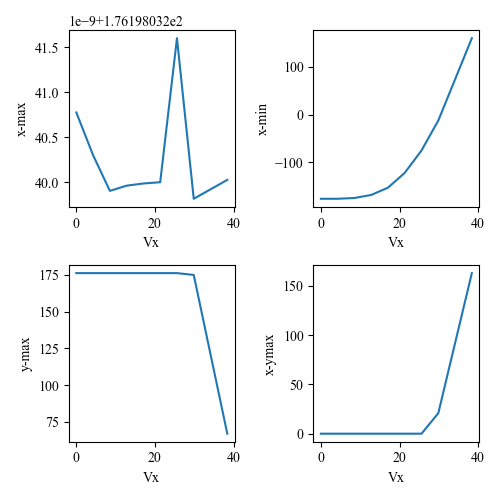

In [65]:
param_idx = 1
param_name = 'Vx'

for data_point in data_points:
    mins, maxs = solve4bounds(hull_5d, data_point)
    reach_data = solve4reachset(param_name, param_idx, (mins[param_idx], maxs[param_idx]), n, data_point, data_bounds)
    fig, axs = visualize(reach_data, param_idx, param_name)
    plt.show()

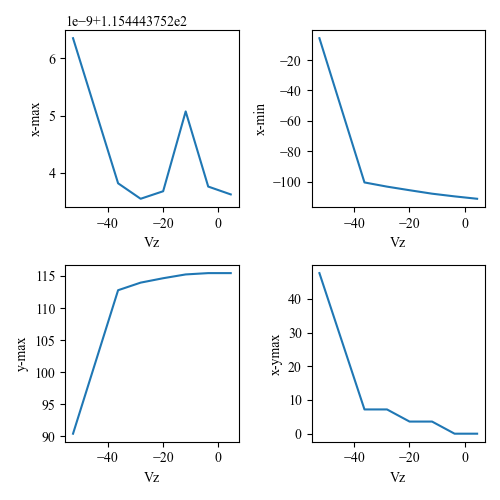

c:\Users\ktomita3\.conda\envs\learn-reach\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


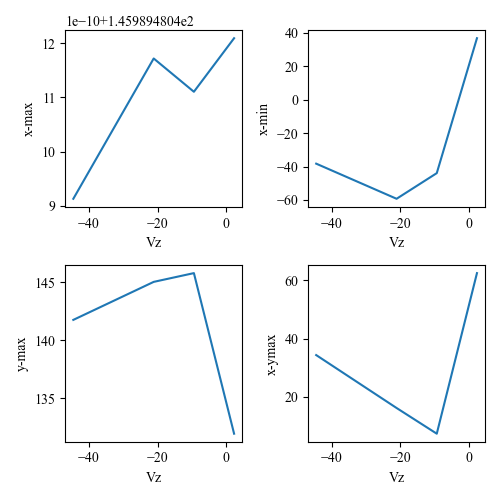

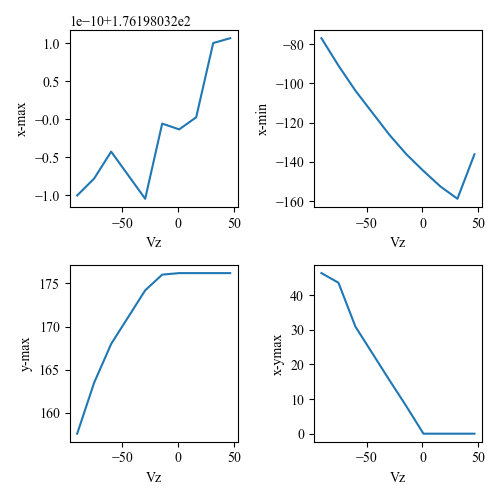

In [66]:
param_idx = 2
param_name = 'Vz'

for data_point in data_points:
    mins, maxs = solve4bounds(hull_5d, data_point)
    reach_data = solve4reachset(param_name, param_idx, (mins[param_idx], maxs[param_idx]), n, data_point, data_bounds)
    visualize(reach_data, param_idx, param_name)
    plt.show()

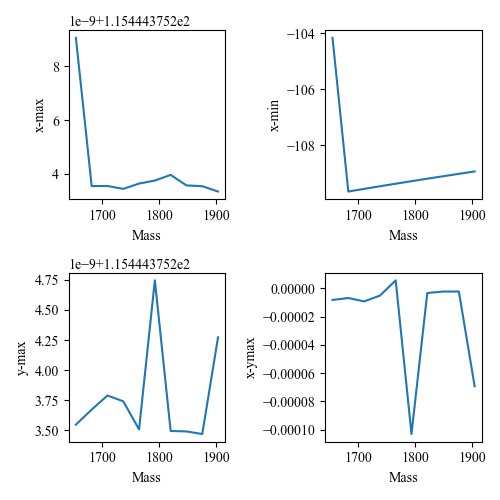

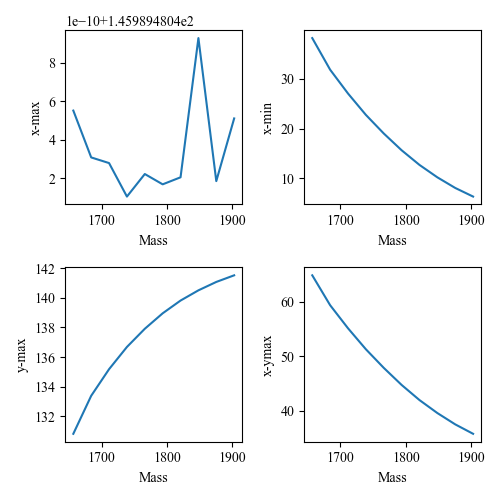

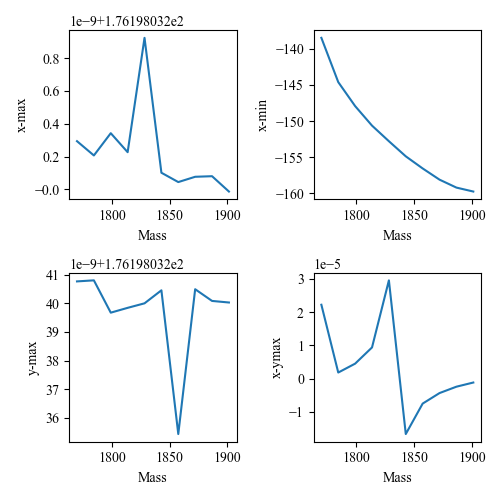

In [67]:
param_idx = 3
param_name = 'Mass'

for data_point in data_points:
    mins, maxs = solve4bounds(hull_5d, data_point)
    reach_data = solve4reachset(param_name, param_idx, (mins[param_idx], maxs[param_idx]), n, data_point, data_bounds)
    visualize(reach_data, param_idx, param_name)
    plt.show()

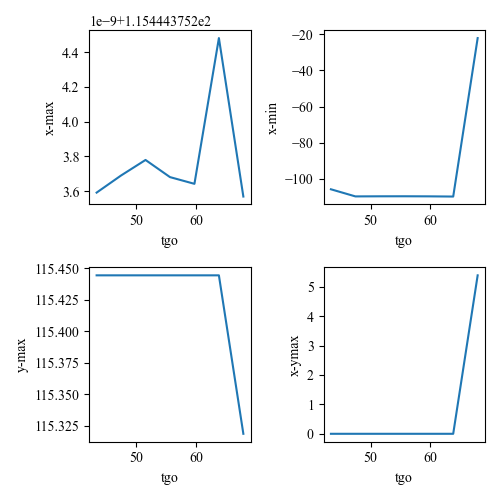

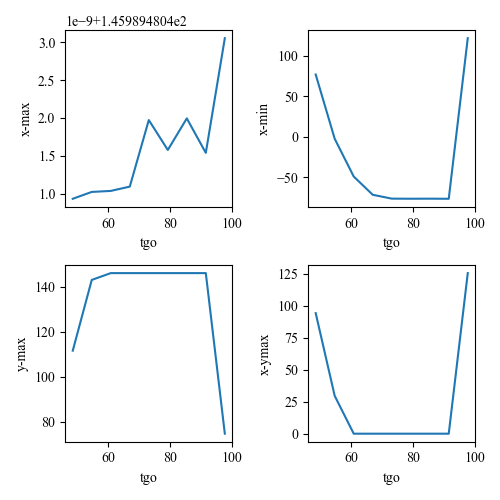

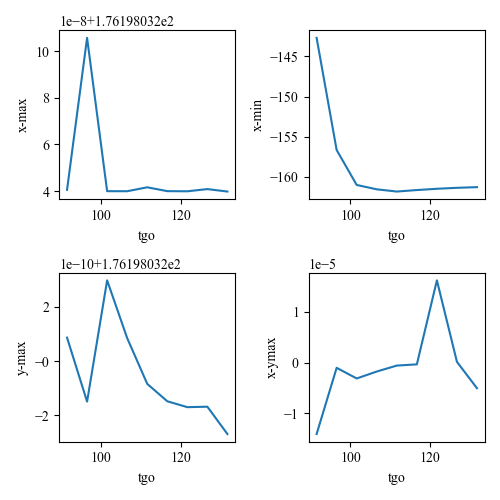

In [68]:
param_idx = 4
param_name = 'tgo'

for data_point in data_points:
    mins, maxs = solve4bounds(hull_5d, data_point)
    reach_data = solve4reachset(param_name, param_idx, (mins[param_idx], maxs[param_idx]), n, data_point, data_bounds)
    visualize(reach_data, param_idx, param_name)
    plt.show()

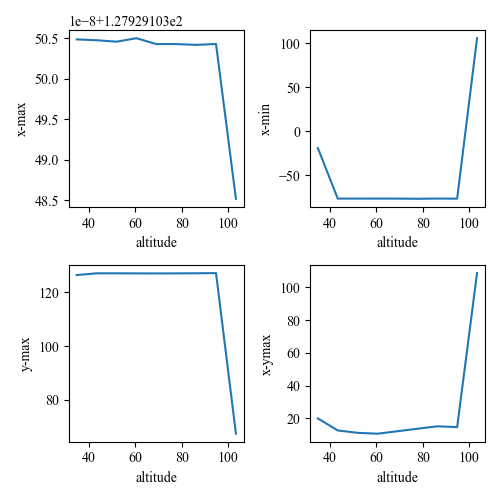

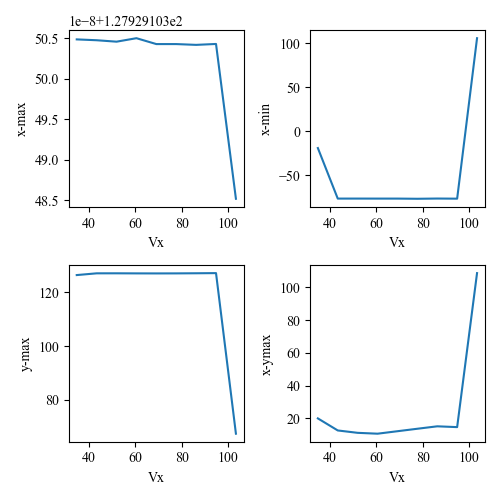

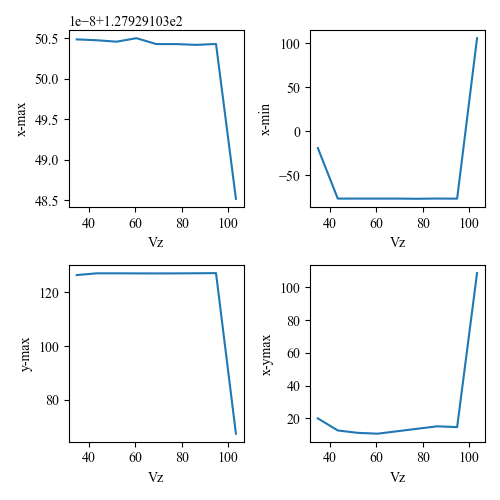

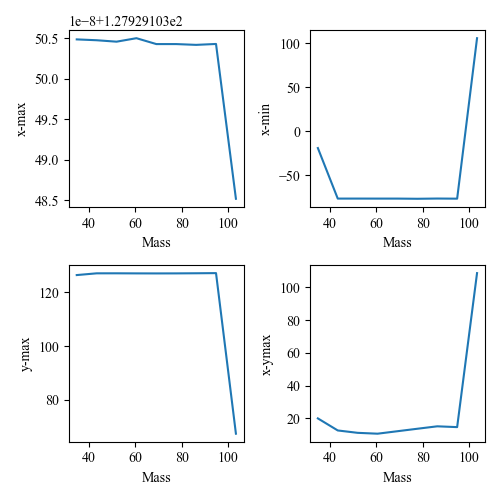

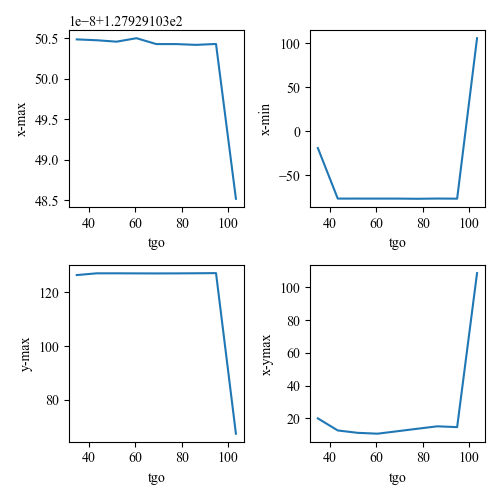

In [69]:
center = np.mean(samples, axis=0)
param_names = ['altitude', 'Vx', 'Vz', 'Mass', 'tgo']
n = 10
for i in range(5):
    param_name = param_names[i]
    mins, maxs = solve4bounds(hull_5d, center)
    reach_data = solve4reachset(param_name, param_idx, (mins[param_idx], maxs[param_idx]), n, center, data_bounds)
    fig, axs = visualize(reach_data, param_idx, param_name)
    plt.show()